In [1]:
# IMPORTS
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg, optimize, constants, interpolate, special, stats
import math as ma
from math import exp, pow, sqrt, log
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms
import keras
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from prettytable import PrettyTable


%matplotlib inline

Using TensorFlow backend.


# CNN 2D Modell

### Daten vorverarbeiten

In [3]:
# csv einlesen
Vein = pd.read_csv('datensatz/vein.csv')
# dataframe draus machen
df = pd.DataFrame(Vein)

#inputs und targets generieren (Spalte 1 für die Targets, Spalte 2 bis Ende für die Inputs)
inputs = df.iloc[1:, 2:].values
targets = df.iloc[1:, 1].values

inputs = inputs.reshape(inputs.shape[0],1,3160, 1).astype( 'float32' )
print('Input Shape : ' , inputs.shape)

inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = 0.3)


#(Anzahl Datenpunkte, Höhe, Breite, Kanäle)  
print('Training data shape : ', inputs_train.shape, targets_train.shape)
print('Testing data shape : ', inputs_test.shape, targets_test.shape)


# INPUTS
inputs_train_max = inputs_train[0].max()
inputs_test_max = inputs_test[0].max()

print('\nVor der Skalierung der Inputs:\n')
print('inputs_train max : ', inputs_train_max)
print('inputs_test max : ', inputs_test_max)


inputs_train_scaled = inputs_train/inputs_train_max
inputs_test_scaled = inputs_test/inputs_test_max

print('\nNach der Skalierung der Inputs:\n')
print('inputs_train max (skaliert): ', inputs_train_scaled[0].max())
print('inputs_test max (skaliert): ', inputs_test_scaled[0].max())


print('\nEin Skalierter Input..\n')
print(inputs_train_scaled[0])


print('\n-----------------')
#TARGETS
targets_train_categorial = to_categorical(targets_train)
targets_test_categorial = to_categorical(targets_test)

x = PrettyTable()
x.field_names = ["target", "!has_DM2", "has_DM2"]

i = 0
for target in targets_train_categorial:
    hasNotDM2, hasDM2 = target
    x.add_row([targets_train[i],hasNotDM2, hasDM2])
    i+=1
print(x)



Input Shape :  (20, 1, 3160, 1)
Training data shape :  (14, 1, 3160, 1) (14,)
Testing data shape :  (6, 1, 3160, 1) (6,)

Vor der Skalierung der Inputs:

inputs_train max :  1638.477
inputs_test max :  751.6617

Nach der Skalierung der Inputs:

inputs_train max (skaliert):  1.0
inputs_test max (skaliert):  1.0

Ein Skalierter Input..

[[[0.05859099]
  [0.05859099]
  [0.05859099]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]

-----------------
+--------+----------+---------+
| target | !has_DM2 | has_DM2 |
+--------+----------+---------+
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  0.0   |   1.0    |   0.0   |
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
|  0.0   |   1.0    |   0.0   |
|  0.0   |   1.0    |   0.0   |
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
+-

### Plotfunktion 

In [4]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# 2. CNN-Modell

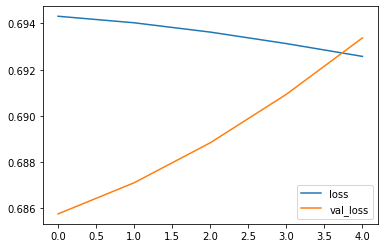

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 3160, 14)       434       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 3160, 10)       4210      
_________________________________________________________________
flatten_1 (Flatten)          (None, 31600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 63202     
Total params: 67,846
Trainable params: 67,846
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
veinModel = Sequential()

veinModel.add(Conv2D(14,                #Anzahl der Filter
              kernel_size=(1,30),        #Dimensionen des Fensters
              strides=(1,1),            #Größe der Schritte
              padding='same',           #Padding: same=dim(in)=dim(out), valid=no Padding
              activation='relu',        #Aktivierungsfunktion
              input_shape=(1,3160,1)))   #Dimension des Inputs

veinModel.add(Conv2D(10, 
              kernel_size=(1,30), 
              strides=(1,1),            #Größe der Schritte
              padding='same',           #Padding: same=dim(in)=dim(out), valid=no Padding
              activation='relu',        #Aktivierungsfunktion
              input_shape=(1,3160,1)))

veinModel.add(Flatten())                       #Feature-Vektor erzeugen
veinModel.add(Dense(2, activation='softmax')) #dicht verschaltete Schicht - lernt Klassifikation!

#backpropagation 
#Stochastic gradient descent
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...

veinModel.compile(
    optimizer=sgd, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#train the model
history_veinModel=veinModel.fit(inputs_train_scaled, targets_train_categorial, 
          epochs=5,
          batch_size=14,
          verbose=1,
          validation_data=(inputs_test_scaled, targets_test_categorial),  
          callbacks=[plot_losses])


print(veinModel.summary())

In [7]:
#Prediction für das erste Bild der Testmenge
result_VeinModel=veinModel.predict(inputs_test_scaled[:])

print ('Auswertung:')
x = PrettyTable()
x.field_names = ["!has_DM2", "has_DM2", "output", "target", "prediction"]

i = 0
for predict in result_VeinModel:
    hasNotDM2, hasDM2 = predict
    output = np.argmax(predict)
    target = np.argmax(targets_test_categorial[i])
    check = '\u2716'
    if target == output:
        check = u'\u2714'
    
    x.add_row([hasNotDM2, hasDM2, output, target, check])
    i+=1
print(x)



Auswertung:
+------------+------------+--------+--------+------------+
|  !has_DM2  |  has_DM2   | output | target | prediction |
+------------+------------+--------+--------+------------+
| 0.49689367 | 0.5031063  |   1    |   0    |     ✖      |
| 0.49669036 | 0.5033096  |   1    |   1    |     ✔      |
| 0.49808243 | 0.50191754 |   1    |   0    |     ✖      |
| 0.49615237 | 0.5038476  |   1    |   1    |     ✔      |
| 0.49763465 | 0.5023654  |   1    |   1    |     ✔      |
| 0.4948913  | 0.5051087  |   1    |   0    |     ✖      |
+------------+------------+--------+--------+------------+
